Date: 11 Nov 2024

In [17]:
import sys

sys.path.append("..")

In [18]:
from dotenv import load_dotenv

_ = load_dotenv("../.env")

In [19]:
from langchain_ollama import ChatOllama
from langchain_anthropic import ChatAnthropic

from src.tools.glad.weekly_alerts_tool import glad_weekly_alerts_tool
from src.tools.location.tool import location_tool

In [20]:
!ollama list

NAME                       ID              SIZE      MODIFIED    
qwen2.5:latest             845dbda0ea48    4.7 GB    5 weeks ago    
nomic-embed-text:latest    0a109f422b47    274 MB    6 weeks ago    
llama3.2:1b                baf6a787fdff    1.3 GB    6 weeks ago    
llama3.2:latest            a80c4f17acd5    2.0 GB    6 weeks ago    


In [35]:
!ollama list

NAME                       ID              SIZE      MODIFIED    
qwen2.5:latest             845dbda0ea48    4.7 GB    5 weeks ago    
nomic-embed-text:latest    0a109f422b47    274 MB    6 weeks ago    
llama3.2:1b                baf6a787fdff    1.3 GB    6 weeks ago    
llama3.2:latest            a80c4f17acd5    2.0 GB    6 weeks ago    


In [36]:
tools = [location_tool, glad_weekly_alerts_tool]
llm = ChatOllama(model="qwen2.5:latest", temperature=0)
# llm = ChatAnthropic(model="claude-3-5-sonnet-20241022", temperature=0)
llm_with_tools = llm.bind_tools(tools)

In [37]:
from IPython.display import Image, display
from langchain_core.messages import HumanMessage, SystemMessage
from langgraph.graph import START, MessagesState, StateGraph
from langgraph.prebuilt import ToolNode, tools_condition

sys_msg = SystemMessage(content="""You are a helpful assistant tasked with answering the user queries for WRI data API.
Use the `location-tool` to get iso, adm1 & adm2 of any region or place.
Use the `glad-weekly-alerts-tool` to get forest fire information for a particular year. Think through the solution step-by-step first and then execute.

For eg: If the query is "Find forest fires in Milan for the year 2024"
Steps
1. Use the `location_tool` to get iso, adm1, adm2 for place `Milan` by passing `query=Milan`
2. Pass iso, adm1, adm2 along with year `2024` as args to `glad-weekly-alerts-tool` to get information about forest fire alerts.
""")

In [38]:
def assistant(state: MessagesState):
    return {"messages": [llm_with_tools.invoke([sys_msg] + state["messages"])]}

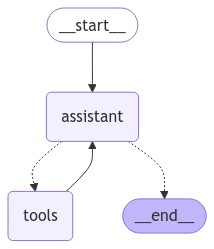

In [39]:
# Graph
builder = StateGraph(MessagesState)

# Define nodes: these do the work
builder.add_node("assistant", assistant)
builder.add_node("tools", ToolNode(tools))

# Define edges: these determine how the control flow moves
builder.add_edge(START, "assistant")
builder.add_conditional_edges(
    "assistant",
    tools_condition,
)
builder.add_edge("tools", "assistant")
react_graph = builder.compile()

# Show
display(Image(react_graph.get_graph(xray=True).draw_mermaid_png()))

In [40]:
messages = [HumanMessage(content="find forest fires in Ihorombe for the year 2021")]
messages = react_graph.invoke({"messages": messages})

In [41]:
for m in messages["messages"]:
    m.pretty_print()

================================ Human Message =================================

find forest fires in Ihorombe for the year 2021
================================== Ai Message ==================================
Tool Calls:
  location-tool (4a6cb8a7-3786-490c-b729-ea9bd9b97ba0)
 Call ID: 4a6cb8a7-3786-490c-b729-ea9bd9b97ba0
  Args:
    query: Ihorombe
================================= Tool Message =================================
Name: location-tool

[{"iso": "MDG", "adm1": 3, "adm2": 4, "names": {"iso": "Madagascar", "adm1": "Fianarantsoa", "adm2": "Ihorombe"}, "score": 100, "match_type": "adm2"}]
================================== Ai Message ==================================
Tool Calls:
  glad-weekly-alerts-tool (c0887400-001d-4b1a-8697-e1138d5850f4)
 Call ID: c0887400-001d-4b1a-8697-e1138d5850f4
  Args:
    adm1: 3
    adm2: 4
    iso: MDG
    year: 2021
================================= Tool Message =================================
Name: glad-weekly-alerts-tool

Error: 2 validati